# 질문 의도 파악 - 선형 모델

In [1]:
import numpy as np
import pandas as pd
import re
import time
from konlpy.tag import Mecab

### 1. 데이터 탐색

In [2]:
df = pd.read_csv('./q_tag.csv', encoding='utf-8')
df.drop('Unnamed: 0', axis=1, inplace=True)
df.shape

(35896, 3)

In [3]:
df.head(2)

,SENTENCE,MAIN,tag
0,지금 배달되나요?,배달가능문의,문의
1,짬뽕류는 어떤 게 있나요? 잘 나가는 짬뽕 있나요?,베스트메뉴문의추천요청,추천


In [4]:
# tag를 한글로 두면 MultiLabelBinarizer에서 오류가 나기 때문에 영어로 바꿔준다.
df.loc[df[df.tag == '문의'].index, 'tag'] = 'Q'
df.loc[df[df.tag == '추천'].index, 'tag'] = 'R'

In [5]:
df.head(2)

,SENTENCE,MAIN,tag
0,지금 배달되나요?,배달가능문의,Q
1,짬뽕류는 어떤 게 있나요? 잘 나가는 짬뽕 있나요?,베스트메뉴문의추천요청,R


### 2. 데이터 전처리


데이터를 train, test로 나눈다.

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df['SENTENCE'].values, df['tag'].values
                                                   ,test_size=0.15) # 디폴트 값은 0.25

In [7]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((26922,), (26922,), (8974,), (8974,))

**Task 1 (TextPrepare).**

In [8]:
KOREAN_RE = re.compile('[^ ㄱ-ㅣ가-힣]+')
STOPWORDS = set(['은','는','이','가','하','아','것','들','의','있','그','되','수','보','주','등','한'
                ,'나','같','우리','때','년','지','오','말','일','그렇','위하','때문','그것'
                ,'두','말하','알','그러나','받','일','또','그런','문제','그리고','크','중','나오','가지'
                ,'시키','지금','생각하','그러','속','하나','집','살','적','월','데','자신','안','어떤'
                ,'내','경우','명','생각','시간','그녀','다시','이런','앞','보이','번','나','다른','어떻','전','들'
                ,'사실','이렇','점','싶','말','정도','좀','원','통하','소리','놓'])

def text_prepare(text):
    
    # 한글과 스페이스바를 제외한 다른 문자들은 모두 지운다.
    text = KOREAN_RE.sub('', text) 
    
    # Mecab 토크나이저
    mecab = Mecab()
    
    # mecab으로 text를 형태소 단위로 나누어 morphs_tokens 리스트에 저장한다.
    # 불용어를 지운다.
    text = ' '.join(token for token in mecab.morphs(text) if token not in STOPWORDS)

    return text

In [9]:
txt = '이제 이 텍스트는 형태소 분석이 된 후 그리고 불용어가 제거될 것입니다. 그러면 무엇이 남을까요 한번 해보죠'
text_prepare(txt)

'이제 텍스트 형태소 분석 된 후 불 용어 제거 될 입니다 그러면 무엇 남 을까요 해 죠'

이제 X_train, X_test의 SENTENCE 데이터를 한글과 공백만 남긴 후, 리스트에 저장한다.

In [10]:
X_train = [text_prepare(x) for x in X_train]
X_test = [text_prepare(x) for x in X_test]

In [11]:
X_train[:3]

['회원 가입 해야 나요', '수학 교재 뭔 가요', '현금영수증 끊 어 줘요']

In [12]:
y_train[:3]

array(['Q', 'Q', 'Q'], dtype=object)

In [13]:
X_test[:3]

['사과 얼마 예요', '저기요 여기 후추 에 요 개', '프라다 스타일 가방 도 나요']

In [14]:
y_test[:3]

array(['Q', 'Q', 'Q'], dtype=object)

**Task 2 (WordsTagsCount).** 

In [15]:
# tag가 train 데이터에서 몇 번 나오는지 count해서 딕셔너리에 저장한다. 
tags_counts = {}
# 각 형태소가 train 데이터에서 몇 번 나오는지 count해서 딕셔너리에 저장한다.
words_counts = {}

for sentence in X_train:
    for word in sentence.split():
        if word in words_counts.keys():
            words_counts[word] += 1
        else:
            words_counts[word] = 1

for tag in y_train:
    if tag in tags_counts.keys():
        tags_counts[tag] += 1
    else:
        tags_counts[tag] = 1

In [16]:
len(tags_counts.keys()), len(words_counts.keys())

(2, 6999)

In [17]:
tags_counts

{'Q': 25333, 'R': 1589}

In [18]:
words_counts

{'회원': 81,
 '가입': 62,
 '해야': 381,
 '나요': 6930,
 '수학': 25,
 '교재': 42,
 '뭔': 80,
 '가요': 451,
 '현금영수증': 46,
 '끊': 28,
 '어': 732,
 '줘요': 34,
 '저희': 85,
 '애': 180,
 '취미': 6,
 '할지': 4,
 '입시': 13,
 '모르': 17,
 '겠': 490,
 '네요': 446,
 '얼마나': 436,
 '걸릴까요': 59,
 '기': 159,
 '에': 4647,
 '이게': 169,
 '천': 200,
 '좋': 425,
 '네': 397,
 '맛있': 228,
 '길래': 3,
 '대박': 1,
 '났': 17,
 '데요': 2,
 '이거': 854,
 '게': 1140,
 '면': 1684,
 '어떻게': 811,
 '돼요': 688,
 '몇': 1634,
 '시': 2037,
 '열': 171,
 '어요': 2543,
 '층': 173,
 '개방': 2,
 '인데': 263,
 '스타일': 93,
 '에요': 823,
 '부터': 294,
 '까지': 709,
 '세요': 810,
 '미용실': 38,
 '해요': 888,
 '제육볶음': 7,
 '더': 426,
 '없': 1204,
 '건가요': 311,
 '쉬': 73,
 '날': 78,
 '언제': 447,
 '인지': 18,
 '을까요': 663,
 '여기': 1286,
 '얼마': 2667,
 '이상': 55,
 '배달': 430,
 '해줘요': 23,
 '분홍색': 8,
 '티셔츠': 42,
 '예요': 1495,
 '메': 37,
 '가방': 441,
 '죠': 1977,
 '한라': 17,
 '봉': 21,
 '인가요': 1359,
 '자몽': 14,
 '청': 8,
 '그냥': 105,
 '따뜻': 66,
 '물': 107,
 '차': 139,
 '처럼': 45,
 '타': 30,
 '먹': 620,
 '어도': 121,
 '거': 2311,
 '커트': 80,
 '

In [19]:
len(X_train), len(y_train), len(X_test), len(y_test)

(26922, 26922, 8974, 8974)

*tags_counts*  : `{'어떤 단어': 빈도수}`
*words_counts* : `{'어떤 단어': 빈도수}`

역시ㅓ 빈도수 대로 sorting을 적용하면 다음과 같이 나타난다. `[('most_popular_word_or_tag', frequency), ('less_popular_word_or_tag', frequency), ...]`. 

    tag1,tag2,tag3
    word1,word2,word3

가장 많이 나온 3단어를 살펴보자.

In [20]:
most_common_tags = sorted(tags_counts.items(), key=lambda x: x[1], reverse=True)[:3]
most_common_words = sorted(words_counts.items(), key=lambda x: x[1], reverse=True)[:3]

In [21]:
print('가장 많이 나온 tag:', most_common_tags)
print('가장 많이 나온 단어:', most_common_words)

가장 많이 나온 tag: [('Q', 25333), ('R', 1589)]
가장 많이 나온 단어: [('나요', 6930), ('에', 4647), ('얼마', 2667)]


### 텍스트 데이터를 벡터로 Transform하기

머신러닝 알고리즘을 돌리기 위해서 텍스트 데이터는 반드시 수치 데이터로 변환되어야 한다. 여러 방법이 있을 수 있지만 우리는 여기서 2가지 방법을 사용한다.

- Bag of words
- TfIdf

#### 1) Bag of words

1. train 데이터에서 가장 많이 나온 N개의 형태소를 찾아서, {형태소:벡터} 형태의 딕셔너리를 만든다.
2. 각각의 SENTENCE 마다 N 차원의 zero vector를 만든다.
3. 각 SENTENCE의 형태소를 iterate하면서 가장 많은 N 차원의 형태소에 해당하는 형태소를 발견하면 해당 벡터에 1을 추가한다.

ex. *N* = 4이고 가장 많이 나온 N개의 형태소가 아래와 같은 예제를 생각해보자.

    ['hi', 'you', 'me', 'are']

위 4개의 단어를 수치화 하여 아래와 같이 나타낸다.

    {'hi': 0, 'you': 1, 'me': 2, 'are': 3}

위 딕셔너리를 이용하여 아래 문장을 벡터화 해보자.

    'hi how are you'

먼저 아래와 같은 4차원의 zero 벡터를 만들어야 한다.

    [0, 0, 0, 0]
    
벡터화 시킬 문장의 모든 형태소를 iterate 하면서, 각 단어가 나올 때마다 해당 벡터에 1을 추가한다.

    'hi':  [1, 0, 0, 0]
    'how': [1, 0, 0, 0] # 'how'는 딕셔너리에 있는 단어가 아니기 때문에 아무 것도 더하지 않는다.
    'are': [1, 0, 0, 1]
    'you': [1, 1, 0, 1]

이에 따라 나온 'hi how are you'의 벡터화 버전:

    [1, 1, 0, 1]
   
이제 5000의 딕셔너리 사이즈를 갖는 *my_bag_of_words* 를 정의하여 train 데이터에서 가장 많이 나온 5000개의 단어를 찾는 함수를 정의한다.

In [22]:
DICT_SIZE = 3000
most_common_words = sorted(words_counts.items(), key=lambda x: x[1], reverse=True)[:DICT_SIZE]
most_common_words = list(zip(*most_common_words))[0]
WORDS_TO_INDEX = {x : i for i, x in enumerate(most_common_words)}
INDEX_TO_WORDS = dict(enumerate(most_common_words))
ALL_WORDS = WORDS_TO_INDEX.keys()

def my_bag_of_words(text, words_to_index, dict_size):
    """
        text: str 타입의 문장
        dict_size: dict_size만큼 가장 많이 나온 단어를 저장한다. dict_size=3000이라면, train 데이터에서 가장 많이 나온 3000단어를 찾는다.
        return 'text' 데이터를 bag-of-words 기법으로 벡터화하여 ndarray 형태로 반환
    """
    
    result_vector = np.zeros(dict_size)
    mecab = Mecab()
    for word in mecab.morphs(text):
        if word in words_to_index.keys():
            if words_to_index[word] < dict_size:
                result_vector[words_to_index[word]] = 1

    return result_vector

위 함수를 train, test 데이터의 모든 문장에 적용하여, 텍스트 데이터를 벡터화시킨 후, 그것을 희소행렬로 나타낸다.

In [23]:
from scipy import sparse as sp_sparse

In [24]:
%%time 

X_train_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) \
                                  for text in X_train])
X_test_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) \
                                 for text in X_test])

print('X_train shape ', X_train_mybag.shape)
print('X_test shape ', X_test_mybag.shape)

X_train shape  (26922, 3000)
X_test shape  (8974, 3000)
CPU times: user 26.9 s, sys: 17.8 s, total: 44.7 s
Wall time: 45 s


여기서 우리는 텍스트 데이터를 수치화 하여 벡터로 만든 후 그것을 다시 희소 행렬로 나타냈다.
희소 행렬에는 다양한 타입이 있다: [type](https://docs.scipy.org/doc/scipy/reference/sparse.html)  <br>
하지만 sklearn 알고리즘은 [csr] 형태만 다룰 수 있기 때문에 여기서는 csr_matrix를 사용한다.(https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html#scipy.sparse.csr_matrix)

**Task 3 (BagOfWords).** *X_train_mybag* 의 처음 11개 행에서 non-zero인 원소는 얼마나 있었는지 살펴본다.

In [25]:
X_train_mybag[10].toarray()

array([[0., 0., 0., ..., 0., 0., 0.]])

In [26]:
X_train_mybag[10].toarray()[0]

array([0., 0., 0., ..., 0., 0., 0.])

In [27]:
for i in range(0,11):
    row = X_train_mybag[i].toarray()[0]
    non_zero_elements_count = row.sum()
    print('index',i,'\trow의 non-zero 원소의 수:', int(non_zero_elements_count))

index 0 	row의 non-zero 원소의 수: 4
index 1 	row의 non-zero 원소의 수: 4
index 2 	row의 non-zero 원소의 수: 4
index 3 	row의 non-zero 원소의 수: 8
index 4 	row의 non-zero 원소의 수: 2
index 5 	row의 non-zero 원소의 수: 6
index 6 	row의 non-zero 원소의 수: 4
index 7 	row의 non-zero 원소의 수: 5
index 8 	row의 non-zero 원소의 수: 5
index 9 	row의 non-zero 원소의 수: 5
index 10 	row의 non-zero 원소의 수: 5


index 3의 데이터를 살펴보자.

In [28]:
# 텍스트 데이터
X_train[3]

'저희 애 취미 할지 입시 할지 모르 겠 네요'

In [29]:
# 벡터화된 데이터
X_train_mybag[3].toarray()

array([[0., 0., 0., ..., 0., 0., 0.]])

#### TF-IDF

TF-IDF 방법은 bag-of-words 기법에서 추가적으로, 형태소 단어의 전체 빈도수를 고려해 해당 형태소 단어가 얼마나 의미 있는 특성인지를 계산해서 스케일을 조정한다.

*tfidf_features* 함수는 *scikit-learn*의 [TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) 을 이용하여 데이터를 벡터화시킨다. 

*train* 데이터를 이용해 vectorizer를 학습시킨다. 이 때 너무 적게 나온 단어를 제거 하려면 min_df 파라미터를 사용한다. <br>
min_df = 5이면, 총 train 데이터에서 5번보다 적게 나온 형태소 단어들은 제거한다. <br>
너무 자주 나온 단어를 제거하려면 max_df 파라미터를 사용한다. <br>
max_df = 0.9이면, train 데이터의 각 SENTENCE에서 90% 이상 나온 단어를 제거한다는 뜻이다. <br>
또한 ngram_range를 이용하여 유니그램까지 고려할 수 있다. <br>

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [31]:
def tfidf_features(X_train, X_test):
    """
        X_train, X_test — 텍스트 데이터
        return TF-IDF 기법으로 벡터화된 데이터
    """
    
    # TF-IDF vectorizer를 생성한다.
    tfidf_vectorizer = TfidfVectorizer(min_df=5
                                      ,max_df=0.9
                                      ,ngram_range=(1,2)
                                      ,token_pattern='(\S+)') #공백을 제거한 모든 문자/숫자/특수문자
    # vectorizer를 train 데이터로 훈련시킨다.
    tfidf_vectorizer.fit(X_train)
    
    # train, test 데이터를 벡터화 하고 (transform) 그 결과를 return 한다.
    X_train = tfidf_vectorizer.transform(X_train)
    X_test = tfidf_vectorizer.transform(X_test)
    
    return X_train, X_test, tfidf_vectorizer.vocabulary_

In [32]:
# 함수의 적용
X_train_tfidf, X_test_tfidf, tfidf_vocab = tfidf_features(X_train, X_test)

In [33]:
# tfidf_vocab에는 각 형태소 단어와 각각의 벡터 표현이 딕셔너리 형태로 들어 있다. (형태소단어 : 벡터화)
tfidf_vocab

{'회원': 6282,
 '가입': 81,
 '해야': 6143,
 '나요': 869,
 '회원 가입': 6283,
 '가입 해야': 85,
 '해야 나요': 6147,
 '수학': 3191,
 '교재': 577,
 '뭔': 2278,
 '가요': 80,
 '뭔 가요': 2279,
 '현금영수증': 6206,
 '끊': 823,
 '어': 3603,
 '줘요': 5287,
 '끊 어': 824,
 '어 줘요': 3625,
 '저희': 4970,
 '애': 3557,
 '취미': 5509,
 '입시': 4837,
 '모르': 2173,
 '겠': 351,
 '네요': 969,
 '저희 애': 4971,
 '모르 겠': 2174,
 '겠 네요': 353,
 '얼마나': 3785,
 '걸릴까요': 295,
 '얼마나 걸릴까요': 3788,
 '기': 721,
 '에': 3842,
 '이게': 4681,
 '천': 5429,
 '좋': 5168,
 '네': 959,
 '기 에': 724,
 '맛있': 1919,
 '났': 913,
 '이거': 4634,
 '게': 302,
 '면': 2064,
 '어떻게': 3674,
 '돼요': 1396,
 '이거 게': 4639,
 '게 면': 324,
 '면 어떻게': 2094,
 '어떻게 돼요': 3681,
 '몇': 2124,
 '시': 3248,
 '열': 4126,
 '어요': 3714,
 '몇 시': 2145,
 '시 에': 3264,
 '에 열': 3935,
 '열 어요': 4132,
 '층': 5512,
 '인데': 4784,
 '스타일': 3235,
 '에요': 4017,
 '부터': 2613,
 '까지': 773,
 '세요': 3032,
 '시 부터': 3262,
 '부터 몇': 2616,
 '시 까지': 3254,
 '까지 세요': 784,
 '미용실': 2301,
 '해요': 6157,
 '까지 해요': 798,
 '제육볶음': 5068,
 '더': 1240,
 '없': 3810,
 '건가요': 272,
 '

In [34]:
# tfidf_vocab 딕셔너리의 key,value를 서로 바꿔준다. -> (벡터화 : 형태소단어)
tfidf_reversed_vocab = {i:word for word,i in tfidf_vocab.items()}

In [35]:
tfidf_reversed_vocab

{6282: '회원',
 81: '가입',
 6143: '해야',
 869: '나요',
 6283: '회원 가입',
 85: '가입 해야',
 6147: '해야 나요',
 3191: '수학',
 577: '교재',
 2278: '뭔',
 80: '가요',
 2279: '뭔 가요',
 6206: '현금영수증',
 823: '끊',
 3603: '어',
 5287: '줘요',
 824: '끊 어',
 3625: '어 줘요',
 4970: '저희',
 3557: '애',
 5509: '취미',
 4837: '입시',
 2173: '모르',
 351: '겠',
 969: '네요',
 4971: '저희 애',
 2174: '모르 겠',
 353: '겠 네요',
 3785: '얼마나',
 295: '걸릴까요',
 3788: '얼마나 걸릴까요',
 721: '기',
 3842: '에',
 4681: '이게',
 5429: '천',
 5168: '좋',
 959: '네',
 724: '기 에',
 1919: '맛있',
 913: '났',
 4634: '이거',
 302: '게',
 2064: '면',
 3674: '어떻게',
 1396: '돼요',
 4639: '이거 게',
 324: '게 면',
 2094: '면 어떻게',
 3681: '어떻게 돼요',
 2124: '몇',
 3248: '시',
 4126: '열',
 3714: '어요',
 2145: '몇 시',
 3264: '시 에',
 3935: '에 열',
 4132: '열 어요',
 5512: '층',
 4784: '인데',
 3235: '스타일',
 4017: '에요',
 2613: '부터',
 773: '까지',
 3032: '세요',
 3262: '시 부터',
 2616: '부터 몇',
 3254: '시 까지',
 784: '까지 세요',
 2301: '미용실',
 6157: '해요',
 798: '까지 해요',
 5068: '제육볶음',
 1240: '더',
 3810: '없',
 272: '건가요',
 1

In [36]:
# shape을 보면 열이 6,345개 있으므로 tfidf를 통해 나온 형태소 벡터가 총 6,345개임을 알 수 있다.
X_train_tfidf.shape, X_test_tfidf.shape

((26922, 6319), (8974, 6319))

### MultiLabel classifier

train/test 데이터에는 태그가 2개 있다. '문의'와 '추천'이다. test 데이터를 보고 태그를 예측하기 위해서는 각 tag 역시 binary 수치형으로 변환시켜야 한다. <br>
이러한 변환을 위해 여기서는 *sklearn*의 MultiLabel Binarizer를 사용한다. [MultiLabelBinarizer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MultiLabelBinarizer.html)

In [37]:
from sklearn.preprocessing import MultiLabelBinarizer

In [38]:
tags_counts

{'Q': 25333, 'R': 1589}

In [39]:
# MultiLabelBinarizer 생성, tag_counts의 key인 '문의','추천'을 count 순으로 sort하여 만든다.
mlb = MultiLabelBinarizer(classes=sorted(tags_counts.keys())) 

In [40]:
mlb

MultiLabelBinarizer(classes=['Q', 'R'], sparse_output=False)

In [48]:
# y_train으로 훈련(fit)시킨 후 벡터화(transform)시키는 함수 fit_transform를 사용한다.
y_train = mlb.fit_transform(y_train)

In [75]:
y_test = mlb.transform(y_test)

Classifier를 훈련시키는 함수 *train_classifier* 를 정의한다. 여기서는 *sklearn*의 One-vs-Rest approach 기법을 사용한다.<br>
[OneVsRestClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html) 

이 방법으로 *k* (= number of tags) 개의 classifier를 훈련시킬 수 있다. 기본적인 분류 방법으로는 [LogisticRegression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) 을 사용한다. 

가장 간단한 방법이지만, 텍스트 분류 작업에서 좋은 성능을 낸다. 분류할 tag가 많을 수록 시간이 많이 걸린다.

In [49]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier

In [50]:
def train_classifier(X_train, y_train):
    """
      X_train, y_train — train 데이터
      return: 훈련된 classifier
    """

    return OneVsRestClassifier(LogisticRegression(penalty= 'l2' #L2 규제 사용
                                                , C = 10
                                                , max_iter = 1000)).fit(X_train, y_train)

우리는 이전에 다음 2가지 벡터화 기법을 사용했다: *bag-of-words*, *tf-idf* <br>
이 2가지 데이터를 이용해 각각의 classifier를 훈련시킨다.

In [51]:
X_train[:10]

['회원 가입 해야 나요',
 '수학 교재 뭔 가요',
 '현금영수증 끊 어 줘요',
 '저희 애 취미 할지 입시 할지 모르 겠 네요',
 '얼마나 걸릴까요',
 '기 에 이게 천 좋 네',
 '얼마나 맛있 길래 대박 났 데요',
 '이거 게 면 어떻게 돼요',
 '몇 시 에 열 어요',
 '층 개방 인데 층 스타일 에요']

In [52]:
classifier_mybag = train_classifier(X_train_mybag, y_train)
classifier_tfidf = train_classifier(X_train_tfidf, y_train)

/anaconda3/envs/text_anal/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/text_anal/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [53]:
classifier_mybag

OneVsRestClassifier(estimator=LogisticRegression(C=10, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=1000,
                                                 multi_class='warn',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='warn', tol=0.0001,
                                                 verbose=0, warm_start=False),
                    n_jobs=None)

이제 test 데이터의 태그를 예측할 수 있다: labels, scores

In [54]:
y_test_predicted_labels_mybag = classifier_mybag.predict(X_test_mybag)
y_test_predicted_scores_mybag = classifier_mybag.decision_function(X_test_mybag)

y_test_predicted_labels_tfidf = classifier_tfidf.predict(X_test_tfidf)
y_test_predicted_scores_tfidf = classifier_tfidf.decision_function(X_test_tfidf)

In [57]:
# bag-of-words로 예측한 tag의 벡터화표현 ('Q' : [1,0], 'R' : [0,1])
y_test_predicted_labels_mybag

array([[1, 0],
       [1, 0],
       [1, 0],
       ...,
       [1, 0],
       [1, 0],
       [1, 0]])

In [71]:
# tf-idf로 예측한 tag의 벡터화표현 ('Q' : [1,0], 'R' : [0,1])
y_test_predicted_labels_tfidf

array([[1, 0],
       [1, 0],
       [1, 0],
       ...,
       [1, 0],
       [1, 0],
       [1, 0]])

이제 몇 개의 데이터에서 TF-IDF를 사용한 분류기가 어떻게 작동하는지 보자:

In [80]:
# 벡터화된 태그를 다시 텍스트 데이터로 변환시킨다.
y_test_pred_inversed = mlb.inverse_transform(y_test_predicted_labels_tfidf)
y_test_pred_inversed

[('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('R',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('R',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('R',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 

In [79]:
y_test_inversed = mlb.inverse_transform(y_test)
y_test_inversed

[('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('R',),
 ('Q',),
 ('R',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('R',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('R',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 ('Q',),
 

In [99]:
for i in range(4):
    print('Title:\t{}\n정답:\t{}\n예측:\t{}\n\n'.format(
        X_test[i],
        ','.join(y_test_inversed[i]),
        ','.join(y_test_pred_inversed[i])
    ))

Title:	사과 얼마 예요
정답:	Q
예측:	Q


Title:	저기요 여기 후추 에 요 개
정답:	Q
예측:	Q


Title:	프라다 스타일 가방 도 나요
정답:	Q
예측:	Q


Title:	어제 맡긴 세탁물 다 완료 됐 어요
정답:	Q
예측:	Q




위 4개의 데이터는 잘 예측이 된 것 같다. 이제 전체 데이터가 얼만큼 예측이 잘 되었는지 살펴보자. 

### Evaluation

모델 평가를 위해 사용할 classification metrics:
 - [Accuracy](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)
 - [F1-score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html)
 - [Area under ROC-curve](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html)
 - [Area under precision-recall curve](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html#sklearn.metrics.average_precision_score) 
 
위 문서에서 micro/macro/weighted averaging 이 무엇인지 잘 살펴보자.

In [83]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score

*print_evaluation_scores* 를 정의하여 정확도를 평가해본다.
 - *accuracy*
 - *F1-score macro/micro/weighted*
 - *Precision macro/micro/weighted*

In [84]:
def print_evaluation_scores(y_test, predicted):
    print('accuracy_score :', accuracy_score(y_test, predicted))

    f1_macro = f1_score(y_test, predicted, average='macro')
    f1_micro = f1_score(y_test, predicted, average='micro')
    f1_weighted = f1_score(y_test, predicted, average='weighted')

    print('F1-score macro :', f1_macro)
    print('F1-score micro :', f1_micro)
    print('F1-score weighted :', f1_weighted)

    print('Precision macro :', average_precision_score(y_test, predicted, average='macro'))
    print('Precision micro :', average_precision_score(y_test, predicted, average='micro'))
    print('Precision weighted :', average_precision_score(y_test, predicted, average='weighted'))

In [85]:
y_test.shape, y_test_predicted_labels_mybag.shape

((8974, 2), (8974, 2))

In [86]:
print('Bag-of-words')
print_evaluation_scores(y_test, y_test_predicted_labels_mybag)
print('Tfidf')
print_evaluation_scores(y_test, y_test_predicted_labels_tfidf)

Bag-of-words
accuracy_score : 0.9636728326275908
F1-score macro : 0.8247410106145391
F1-score micro : 0.9636728326275908
F1-score weighted : 0.962003564177872
Precision macro : 0.7248742821613412
Precision micro : 0.9468289120306892
Precision weighted : 0.9447049328883415
Tfidf
accuracy_score : 0.9681301537775797
F1-score macro : 0.8378336915877812
F1-score micro : 0.9681301537775797
F1-score weighted : 0.9657004584359002
Precision macro : 0.7454713004854169
Precision micro : 0.9532109177646103
Precision weighted : 0.9467816840067592


정확도가 96%이다.

You might also want to plot some generalization of the [ROC curve](http://scikit-learn.org/stable/modules/model_evaluation.html#receiver-operating-characteristic-roc) for the case of multi-label classification. Provided function *roc_auc* can make it for you. The input parameters of this function are:
 - true labels
 - decision functions scores
 - number of classes

In [92]:
# 이건 지금 오류가 나서 나중에
from metrics import roc_auc
%matplotlib inline

ImportError: cannot import name 'roc_auc'

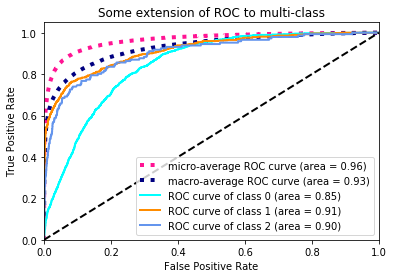

In [55]:
n_classes = len(tags_counts)
roc_auc(y_test, y_test_predicted_scores_mybag, n_classes)

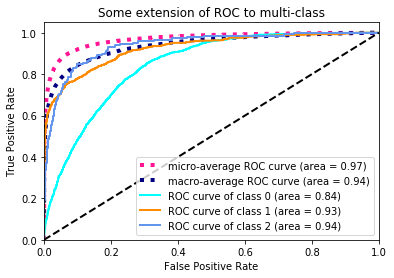

In [56]:
n_classes = len(tags_counts)
roc_auc(y_test, y_test_predicted_scores_tfidf, n_classes)

**Task 4 (MultilabelClassification).** 

- bag-of-words, TF-IDF의 성능을 비교해본다.
- *L1*, *L2* 규제를 각각 사용해본다.
- C (coefficients) 값을 달리 해본다. (0.1, 1, 10, 100) -> 가장 예측도가 높은 C 값을 찾는다.

In [94]:
from sklearn.svm import LinearSVC
classifier_mybag = OneVsRestClassifier(LinearSVC(C = 1)).fit(X_train_mybag, y_train) # C값 변화시켜본다.
classifier_tfidf = OneVsRestClassifier(LinearSVC(C = 1)).fit(X_train_tfidf, y_train) # C값 변화시켜본다.

y_test_predicted_labels_mybag = classifier_mybag.predict(X_test_mybag)
y_test_predicted_scores_mybag = classifier_mybag.decision_function(X_test_mybag)

y_test_predicted_labels_tfidf = classifier_tfidf.predict(X_test_tfidf)
y_test_predicted_scores_tfidf = classifier_tfidf.decision_function(X_test_tfidf)
y_test_pred_inversed = mlb.inverse_transform(y_test_predicted_labels_tfidf)
y_test_inversed = mlb.inverse_transform(y_test)
for i in range(3):
    print('Title:\t{}\n답:\t{}\n예측:\t{}\n\n'.format(
        X_test[i],
        ','.join(y_test_inversed[i]),
        ','.join(y_test_pred_inversed[i])
    ))
    
print('F1 Score weighted\nTFIDF:\t{}\tBOW:\t{}\n'
          .format(f1_score(y_test, y_test_predicted_labels_tfidf, average='weighted'), 
                  f1_score(y_test, y_test_predicted_labels_mybag, average='weighted')))

Title:	사과 얼마 예요
답:	Q
예측:	Q


Title:	저기요 여기 후추 에 요 개
답:	Q
예측:	Q


Title:	프라다 스타일 가방 도 나요
답:	Q
예측:	Q


F1 Score weighted
TFIDF:	0.9671916651339877	BOW:	0.9610493975692884



원하는 질문을 직접 만들어서 우리 모델이 잘 예측하는지 알아본다.

In [109]:
len(y_chatbot)

6

In [112]:
X_chatbot = [
    '맛있는 파스타집 추천해주세요'
    , '종로에 분위기 좋은 순대국밥집 있나요?'
    , '서울에 데이트하기 좋은 파스타집 추천해주세요.'
    , '그 순대국밥 집 주소가 어떻게 되나요?'
    , '그 파스타집 전화번호좀 알려주세요.'
    , '그 순대국밥 집 어때요?'
]
y_chatbot = [
    'R','R','R','Q','Q','Q'
]

# SENTENCE 데이터 전처리
X_chatbot = [text_prepare(x) for x in X_chatbot]

# bag-of-words
X_chatbot_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) \
                                  for text in X_chatbot])

# tf-idf
_, X_chatbot_tfidf, _ = tfidf_features(X_train, X_chatbot)

# tag 데이터 전처리
y_chatbot = mlb.transform(y_chatbot)

# tag 예측
y_chatbot_predicted_labels_mybag = classifier_mybag.predict(X_chatbot_mybag)
y_chatbot_predicted_scores_mybag = classifier_mybag.decision_function(X_chatbot_mybag)

y_chatbot_predicted_labels_tfidf = classifier_tfidf.predict(X_chatbot_tfidf)
y_chatbot_predicted_scores_tfidf = classifier_tfidf.decision_function(X_chatbot_tfidf)

# 예측된 tag를 텍스트로 변환
y_chatbot_pred_inversed = mlb.inverse_transform(y_chatbot_predicted_labels_tfidf)
y_chatbot_inversed = mlb.inverse_transform(y_chatbot)

for i in range(0,len(y_test)):
    print('SENTENCE:\t{}\n정답:\t{}\n예측:\t{}\n\n'.format(
        X_chatbot[i],
        ','.join(y_chatbot_inversed[i]),
        ','.join(y_chatbot_pred_inversed[i])
    ))

SENTENCE:	맛있 파스타 추천 해 세요
정답:	R
예측:	R


SENTENCE:	종로 에 분위기 좋 순대 국밥 나요
정답:	R
예측:	Q


SENTENCE:	서울 에 데이트 기 좋 파스타 추천 해 세요
정답:	R
예측:	Q


SENTENCE:	순대 국밥 주소 어떻게 나요
정답:	Q
예측:	Q


SENTENCE:	파스타 전화 번호 알려 세요
정답:	Q
예측:	Q


SENTENCE:	순대 국밥 어때요
정답:	Q
예측:	Q




IndexError: list index out of range

- '분위기 좋은 순대국밥 집 있나요?', '서울에 분위기 좋은 파스타 집 있나요?' 이 질문의 태그 예측에 실패했다.
- 우리 챗봇의 핵심 기능인 식당 추천을 하지 못하므로 챗봇 용 질문 데이터를 새로 만들어 훈련해야 할 필요가 있다.